# Week 5A: More Geospatial Analysis: Urban Networks

- Monday, October 2, 2023
- Section 401

In [ ]:
# The usual imports
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
# Show all columns in dataframes
pd.options.display.max_columns = 999

In [ ]:
# Hide warnings due to issue in shapely package 
# See: https://github.com/shapely/shapely/issues/1345
np.seterr(invalid="ignore");

## Today: Urban street networks and OpenStreetMap (OSM)

- Two tools that make working with OSM data very easy
- What kind of questions can we answer?
    - Street orientations 
    - Mapping event points to streets: car crashes
    - Mapping amenities
    - Network-constrained distances: accessibility

## OSM: what is it?

- Collaborative mapping
- A free editable map of the World
- Sort of like Wikipedia for maps

**Great source of data: street networks and a wealth of amenity information**

https://www.openstreetmap.org

## Working with OSM data

- Raw data is very messy
- Two relatively new, amazing Python packages greatly simply the process
- Related, but complementary features    
    - **OSMnx:** downloading and manipulating streets as networks
    - **Pandana:** networks focused on accessibility of amenities
    
**Related:** interactive web maps in Python

## Part 1: OSMnx

Relatively new package (just a few years old), but quickly becoming the go to package for working with street networks and OpenStreetMap data in Python.

Several key features: 

- Downloading political boundaries for cities, states, countries, etc
- Downloading street networks
- Analyzing networks: routing, visualization, statistics

  - [GitHub](https://github.com/gboeing/osmnx)
  - [Introductory Blog Post](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Jupyter Notebook Examples](https://github.com/gboeing/osmnx-examples/tree/master/notebooks) ([Binder](https://mybinder.org/v2/gh/gboeing/osmnx-examples/main?urlpath=/tree/notebooks))
  - [Documentation](https://osmnx.readthedocs.io)

In [16]:
import osmnx as ox

### 1.1. Getting boundary shapefiles from OSM

Key function: `geocode_to_gdf()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.geocoder.geocode_to_gdf))

We can get the boundary for anything identified as a "place" by OSM.

**Important: Be careful to pass the right place name that OSM needs**

In [31]:
Honiara = ox.geocode_to_gdf("Honiara, Solomon Islands")
Honiara.head()

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((159.91731 -9.41273, 159.91800 -9.423...",-9.412725,-9.45849,160.022725,159.917309,55683639,relation,2536278,-9.437798,159.962417,boundary,administrative,8,0.55001,state,Honiara,"Honiara, Solomon Islands"


In [32]:
Honiara.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can plot it just like any other GeoDataFrame

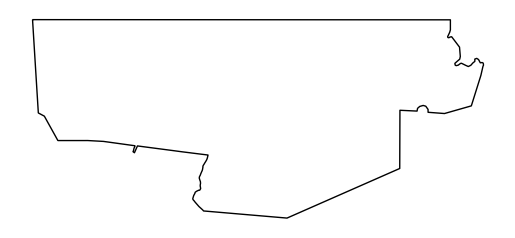

In [33]:
# Project it to Web Mercator first and plot
ax = Honiara.to_crs(epsg=3857).plot(facecolor="none", edgecolor="black")
ax.set_axis_off()

### 1.2 Projecting with OSMnx

Key function: `project_gdf()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_gdf))

Automatically projects to the [Universal Transverse Mercator](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) (UTM) CRS for the UTM zone that the centroid of the polygon lies in 

A good, general projection that works for most latitudes except very northern locations.

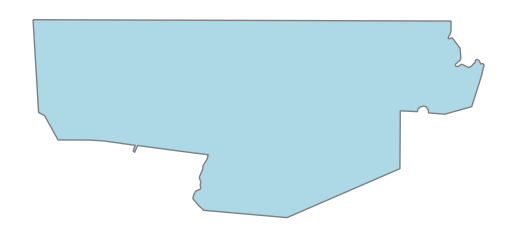

In [34]:
ax = ox.project_gdf(Honiara).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

Some more examples:

### 1.3 Downloading OSM features

Key functions: `features_from_*`

- `features_from_place()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_place))
     - Download features within an OSM place boundary
- `features_from_address()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_address))
    - Download features within a certain distance of an address
- `features_from_bbox()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_bbox))
    - Download features within a N, S, E, W bounding box
- `features_from_point()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_point)) 
    - Download features within a certain distance of a specified point
- `features_from_polygon()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_polygon))
    - Download features within a polygon object

::: {.callout-note}
### About OSM features

**Important reference:** https://wiki.openstreetmap.org/wiki/Map_Features

- OSM uses a *tagging* system to categorize different map features
- The main feature categories are available on the OSM Wikipedia
    - Examples: 'amenity', 'building', 'landuse', 'highway'
- There are specific sub-categories for each feature type too:
    - Amenity examples: 'bar', 'college', 'library'

In the language of OSM, the "key" is the main feature category (e.g., amenity) and the "value" is the sub-category type (e.g., "bar")
:::

`osmnx` mirrors the key/value syntax of OSM. Use a dict to specify the features you want: 

In [35]:
# Get all amenities in Philadelphia
amenities = ox.features_from_place("Honiara, Solomon Islands", tags={"amenity": True})

In [36]:
len(amenities)

101

In [37]:
amenities.head()

amenity               name         source  \
element_type osmid                                                 
node         693014217  police  Rove Headquarters  approximation   
             693014237    fuel                NaN            NaN   
             693014246  casino                NaN  approximation   
             693021926    bank        Centralbank            NaN   
             693021929    fuel     Solomon Motors  approximation   

                                          geometry emergency healthcare  \
element_type osmid                                                        
node         693014217  POINT (159.94302 -9.42899)       NaN        NaN   
             693014237  POINT (159.96662 -9.43883)       NaN        NaN   
             693014246  POINT (159.95755 -9.43145)       NaN        NaN   
             693021926  POINT (159.95294 -9.43090)       NaN        NaN   
             693021929  POINT (159.95498 -9.43078)       NaN        NaN   

                       denomination religion cuisine  atm internet_access  \
element_type osmid                                                          
node         693014217          NaN      NaN     NaN  NaN             NaN   
             693014237          NaN      NaN     NaN  NaN             NaN   
             693014246          NaN      NaN     NaN  NaN             NaN   
             693021926          NaN      NaN     NaN  NaN             NaN   
             693021929          NaN      NaN     NaN  NaN             NaN   

                       opening_hours operator name:en  bus public_transport  \
element_type osmid                                                            
node         693014217           NaN      NaN     NaN  NaN              NaN   
             693014237           NaN      NaN     NaN  NaN              NaN   
             693014246           NaN      NaN     NaN  NaN              NaN   
             693021926           NaN      NaN     NaN  NaN              NaN   
             693021929           NaN      NaN     NaN  NaN              NaN   

                       addr:city fuel:Petrol fuel:diesel fuel:kerosene  \
element_type osmid                                                       
node         693014217       NaN         NaN         NaN           NaN   
             693014237       NaN         NaN         NaN           NaN   
             693014246       NaN         NaN         NaN           NaN   
             693021926       NaN         NaN         NaN           NaN   
             693021929       NaN         NaN         NaN           NaN   

                       drive_through addr:street website phone note  \
element_type osmid                                                    
node         693014217           NaN         NaN     NaN   NaN  NaN   
             693014237           NaN         NaN     NaN   NaN  NaN   
             693014246           NaN         NaN     NaN   NaN  NaN   
             693021926           NaN         NaN     NaN   NaN  NaN   
             693021929           NaN         NaN     NaN   NaN  NaN   

                       contact:facebook craft level shop nodes building  \
element_type osmid                                                        
node         693014217              NaN   NaN   NaN  NaN   NaN      NaN   
             693014237              NaN   NaN   NaN  NaN   NaN      NaN   
             693014246              NaN   NaN   NaN  NaN   NaN      NaN   
             693021926              NaN   NaN   NaN  NaN   NaN      NaN   
             693021929              NaN   NaN   NaN  NaN   NaN      NaN   

                       building:levels outdoor_seating smoking start_date  \
element_type osmid                                                          
node         693014217             NaN             NaN     NaN        NaN   
             693014237             NaN             NaN     NaN        NaN   
             693014246             NaN             NaN     NaN        NaN  

In [38]:
# Get bus stop features
bus_stops = ox.features_from_place("Honiara, Solomon Islands", tags={"highway": "secondary"})

In [39]:
len(bus_stops)

24

In [40]:
bus_stops.head()

nodes  \
element_type osmid                                                          
way          30711700                              [339661166, 339661164]   
             30711701   [6806772554, 6813071845, 6813071846, 681307184...   
             30711704                              [339661623, 339661621]   
             161841698  [1737969008, 5706121101, 5706121100, 339661756...   
             161841700  [1737969113, 1737968994, 1737969141, 173796900...   

                       bridge    highway layer oneway  \
element_type osmid                                      
way          30711700     yes  secondary     1    yes   
             30711701     NaN  secondary   NaN    yes   
             30711704     yes  secondary     1    yes   
             161841698    NaN  secondary   NaN    yes   
             161841700    NaN  secondary   NaN    NaN   

                                                                 geometry  \
element_type osmid                                                          
way          30711700   LINESTRING (159.96729 -9.43605, 159.96664 -9.4...   
             30711701   LINESTRING (160.02792 -9.42829, 160.02787 -9.4...   
             30711704   LINESTRING (159.96666 -9.43597, 159.96728 -9.4...   
             161841698  LINESTRING (160.00497 -9.42856, 160.00501 -9.4...   
             161841700  LINESTRING (160.00486 -9.42852, 160.00490 -9.4...   

                                 name    junction fixme  
element_type osmid                                       
way          30711700             NaN         NaN   NaN  
             30711701   Kukum Highway         NaN   NaN  
             30711704             NaN         NaN   NaN  
             161841698  Kukum Highway         NaN   NaN  
             161841700            NaN  roundabout   NaN

In [45]:
# Get commercial and retail landuse features
landuse = ox.features_from_place(
    "Honiara, Solomon Islands", tags={"landuse": ["commercial", "retail"]}
)

In [46]:
len(landuse)

32

Let's plot the land use features:

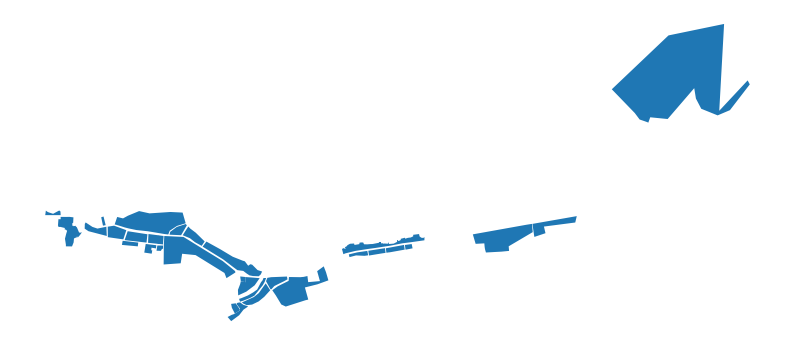

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = landuse.plot(ax=ax)
ax.set_axis_off()

### 1.4 Downloading street networks

Key functions: `graph_from_*` 

- `graph_from_place()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place))
     - Download street network within an OSM place boundary
- `graph_from_address()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_address))
    - Download street network within a certain distance of an address
- `graph_from_bbox()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_bbox))
    - Download street network within a N, S, E, W bounding box
- `graph_from_point()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_point)) 
    - Download street network within a certain distance of a specified point
- `graph_from_polygon()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_polygon))
    - Download street network within a polygon object

#### Street network around an address

Get streets within 500 meters of the center of Center City

In [49]:
G = ox.graph_from_place("Honiara, Solomon Islands", dist=500)

TypeError: graph_from_place() got an unexpected keyword argument 'dist'

Project and plot it:

In [ ]:
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected);

Remove the nodes:

In [ ]:
ox.plot_graph(G_projected, node_size=0);

Let's zoom out to 2,000 meters. This will take a little longer.

In [ ]:
G = ox.graph_from_address("Center City, Philadelphia, PA", dist=2000)
G_projected = ox.project_graph(G)

In [ ]:
ox.plot_graph(G_projected, node_size=0);

#### Getting different network types

- `drive` - get drivable public streets (but not service roads)
- `drive_service` - get drivable streets, including service roads
- `walk` - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
- `bike` - get all streets and paths that cyclists can use
- `all` - download all non-private OSM streets and paths
- `all_private` - download all OSM streets and paths, including private-access ones (default)

In [ ]:
# the "drive" network
G = ox.graph_from_address("Center City, Philadelphia, PA", network_type="drive")
ox.plot_graph(G);

In [ ]:
# the "walk" network
G = ox.graph_from_address("Center City, Philadelphia, PA", network_type="walk")
ox.plot_graph(ox.project_graph(G));

#### Street network within a place boundary

Use `graph_from_place()` to get the streets within a specific OSM place.

::: {.callout-caution}

A couple of things to watch out for: 
1. The place query has to be resolved by OSM.
2. If the place is a big city, you might be downloading a lot of data!

:::

Let's check out the street network for Berkeley, CA:

In [ ]:
berkeley = ox.graph_from_place("Berkeley, California, USA")

In [ ]:
ox.plot_graph(ox.project_graph(berkeley), node_size=0);

#### Streets within a specific polygon

**Example:** Let's download all streets within Center City. We will use the "Central" planning district as a proxy for this area. The city's planning districts are available on [Open Data Philly](https://opendataphilly.org/datasets/planning-districts/).

In [ ]:
planning_districts = gpd.read_file(
    "https://opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson"
)

In [ ]:
planning_districts.head()

Trim to the central district:

In [ ]:
central_district = planning_districts.query("DIST_NAME == 'Central'")

And plot it:

In [ ]:
ax = ox.project_gdf(central_district).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

Squeeze it so we can get the geometry polygon:

In [ ]:
center_city_outline = central_district.squeeze().geometry

center_city_outline

Now, let's use `ox.graph_from_polygon()` to extract streets within this polygon. 

In [ ]:
# Get the graph
G_cc = ox.graph_from_polygon(Solomon Islands, network_type="drive")

In [ ]:
# Viola!
ox.plot_graph(ox.project_graph(G_cc), node_size=0);

### 1.5 Converting from a graph to a GeoDataFrame

Key function: `ox.graph_to_gdfs()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=graph_to_gdf#osmnx.utils_graph.graph_to_gdfs))

You can get a GeoDataFrame for both the nodes (points) and edges (lines)

In [ ]:
type(G_cc)

In [ ]:
# only get the edges
cc_edges = ox.graph_to_gdfs(G_cc, edges=True, nodes=False)

In [ ]:
# we have lots of data associated with each edge!
cc_edges.head()

In [ ]:
# plot it like any old GeoDataFrame
ax = cc_edges.to_crs(epsg=3857).plot(color="gray")

# add the neighborhood boundaries
boundary = gpd.GeoSeries([center_city_outline], crs="EPSG:4326")
boundary.to_crs(epsg=3857).plot(
    ax=ax, facecolor="none", edgecolor="red", linewidth=3, zorder=2
)

ax.set_axis_off()

**Don't forget:** We can use the `.explore()` function to get an interactive web map via Folium:

In [ ]:
cc_edges.explore(tiles='cartodb positron')

### 1.6 What can we do with the graph?

- Network-based statistics
- Routing
- Street orientations
- Visualizing crashes

And much more: see the [OSMnx repository of Jupyter notebook examples](https://github.com/gboeing/osmnx-examples/tree/master/notebooks)

#### Street orientations

A [great blog post](https://geoffboeing.com/2019/09/urban-street-network-orientation/) on street orientations across different US and global cities. 

One of my favorite examples of data viz, using matplotlib for *radial histograms* of street orientations...



![](imgs/street-orientations.png){width=800}

The code for these histograms is available in [the osmnx examples repository](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/17-street-network-orientations.ipynb).

#### Network statistics

We can use the `ox.basic_stats()` to get some basic network statistics

In [ ]:
ox.basic_stats(G_cc)

#### Finding the shortest route

Let's calculate the shortest route between [the Art Museum](https://www.openstreetmap.org/way/28533972) and the [Liberty Bell](https://www.openstreetmap.org/node/1207480649).

We'll need to download all amenities in Philadelphia of type "tourism".

- The `ox.features_from_place()` can download OSM features with a specific tag
- You can consult the OSM pages ([the Art Museum](https://www.openstreetmap.org/way/28533972) and [Liberty Bell](https://www.openstreetmap.org/node/1207480649)) for each feature for additional info
- Both features are categorized as "tourism" in the OSM data — use the "tags" keyword to select this category

In [ ]:
philly_tourism = ox.features_from_place("Philadelphia, PA", tags={"tourism": True})

In [ ]:
len(philly_tourism)

In [ ]:
philly_tourism.head()

In [ ]:
# How to find the name of the POI: search for keywords
philly_tourism.loc[philly_tourism['name'].str.contains("Art", na=False)]

In [ ]:
art_museum = philly_tourism.query("name == 'Philadelphia Museum of Art'").squeeze()

art_museum.geometry

In [ ]:
liberty_bell = philly_tourism.query("name == 'Liberty Bell'").squeeze()

liberty_bell.geometry

Now, extract the lat and lng coordinates

For the Art Museum geometry, we can use the `.geometry.centroid` attribute to calculate the centroid of the building footprint. 

In [ ]:
liberty_bell_x = liberty_bell.geometry.x
liberty_bell_y = liberty_bell.geometry.y

In [ ]:
art_museum_x = art_museum.geometry.centroid.x
art_museum_y = art_museum.geometry.centroid.y

Find the nearest nodes on our OSMnx graph, using the `ox.nearest_nodes()` function


In [ ]:
ox.nearest_nodes?

In [ ]:
# Get the origin node
orig_node = ox.nearest_nodes(G_cc, liberty_bell_x, liberty_bell_y) 

# Get the destination node
dest_node = ox.nearest_nodes(G_cc, art_museum_x, art_museum_y)

Now, we can use `ox.shortest_path()` function to find the shortest path between these graph nodes.

::: {.callout-note}
We need to specify weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).
:::

In [ ]:
# get the shortest path --> just a list of node IDs
route1 = ox.shortest_path(G_cc, orig_node, dest_node, weight="length")

route1

Use `ox.plot_graph_route()` to plot a graph and highlight a specific route

In [ ]:
ox.plot_graph_route(G_cc, route1, node_size=0);

How about an interactive version?

`osmnx` has a helper function `ox.utils_graph.route_to_gdf()` to convert a route to a GeoDataFrame of edges.

In [ ]:
ox.utils_graph.route_to_gdf(G_cc, route1, weight="length").explore(
    tiles="cartodb positron",
    color="red",
)

#### Finding the shortest travel time


The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. 

The function will add free-flow travel speeds for all edges based on the average `maxspeed` value of edges, per highway type. This process can definitely be imprecise, but in the case that you happen to have more precise speed data, you can supply your own data instead of relying on OSM data. 

In [ ]:
# impute speed on all edges missing data
G_cc = ox.add_edge_speeds(G_cc)

# calculate travel time (seconds) for all edges
G_cc = ox.add_edge_travel_times(G_cc)

In [ ]:
# Get the graph edges
edges = ox.graph_to_gdfs(G_cc, nodes=False)

In [ ]:
edges.head()

In [ ]:
# Groupby highway type and get the mean values
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean()

In [ ]:
# calculate two routes by minimizing travel time
route2 = ox.shortest_path(G_cc, orig_node, dest_node, weight="travel_time")

In [ ]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G_cc,
    routes=[route1, route2],
    route_colors=["r", "y"],
    route_linewidth=6,
    node_size=0,
)

Let's plot both in an interactive map:

In [ ]:
m = ox.utils_graph.route_to_gdf(G_cc, route1, weight="length").explore(
    tiles="cartodb dark matter",
    color="red",
)

m = ox.utils_graph.route_to_gdf(G_cc, route2, weight="length").explore(
    tiles="cartodb dark matter",
    color="yellow",
    m=m
)

m

Let's compare to the two routes:

Distances:

In [ ]:
meters_to_miles = 0.0006213712

# compare the two routes
route1_length = (
    ox.utils_graph.route_to_gdf(G_cc, route1, weight="length")["length"].sum()
    * meters_to_miles
)

route2_length = (
    ox.utils_graph.route_to_gdf(G_cc, route2, weight="length")["length"].sum()
    * meters_to_miles
)

Travel times:

In [ ]:
seconds_to_mins = 1.0 / 60

route1_time = (
    ox.utils_graph.route_to_gdf(G_cc, route1, weight="travel_time")["travel_time"].sum()
    * seconds_to_mins
)
route2_time = (
    ox.utils_graph.route_to_gdf(G_cc, route2, weight="travel_time")["travel_time"].sum()
    * seconds_to_mins
)

Summarize:

In [ ]:
print(f"Route 1 is {route1_length:.2f} miles and takes {route1_time:.2f} minutes.")
print(f"Route 2 is {route2_length:.2f} miles and takes {route2_time:.2f} minutes.")

## Part 2:  Pandana

"Pandas Network Analysis - dataframes of network queries, quickly"

A complementary set of OSM-related features: 
- Downloading OSM-based networks
- Extracting amenity data (so-called "Points of Interest")
- Calculating network-constrained distances

- [GitHub](https://github.com/UDST/pandana)
- [Jupyter Notebook Examples](https://github.com/UDST/pandana/tree/master/examples)
- [Documentation](http://udst.github.io/pandana/)

In [ ]:
import pandana as pnda
from pandana.loaders import osm

### Step 1: Get amenity data

Key function: `osm.node_query()`

- This will extract amenities within a given bounding box.
- Similar to the `ox.geometries_from_bbox()` function in OSMnx, but we slightly different syntax.

In [ ]:
osm.node_query?

Get the bounding box for Northern Liberties / Fishtown:

In [ ]:
boundary = center_city_outline.bounds
boundary

In [ ]:
[lng_min, lat_min, lng_max, lat_max] = boundary

In [ ]:
# query OSM
poi_df = osm.node_query(lat_min, lng_min, lat_max, lng_max)

# remove missing data
poi_df = poi_df.dropna(subset=["amenity"])

In [ ]:
poi_df.head()

In [ ]:
len(poi_df)

In [ ]:
poi_df[["lat", "lon", "amenity"]].head(10)

#### Explore the amenities in this region

For the full list of amenities, see the [OSM Wikipedia](https://wiki.openstreetmap.org/wiki/Key:amenity)

In [ ]:
chart = (
    alt.Chart(poi_df)
    .mark_bar()
    .encode(y=alt.Y("amenity", sort="-x"), x="count()", tooltip=["amenity", "count()"])
)

chart

### Step 2: Create a Pandana network

- Key function: `pdna_network_from_bbox()` 
- It takes a bounding box and returns the OSM network within that region. 
- Multiple network types: 'walk' and 'drive'

In [ ]:
net = osm.pdna_network_from_bbox(
    lat_min, lng_min, lat_max, lng_max, network_type="walk"
)

### Step 3: Tell the network the location of amenities

Key function: `network.set_pois()`

- Today, we'll explore these four amenities: "restaurant", "bar", "school", "car_sharing"
- **IMPORTANT:** if you want to explore other amenities, you'll need to run the code below for your amenities of interest

In [ ]:
# sensible defaults
max_distance = 2000  # in meters
num_pois = 10  # only need the 10 nearest POI to each point in the network


AMENITIES = ["restaurant", "bar", "school", "car_sharing"]
for amenity in AMENITIES:
    # get the subset of amenities for this type
    pois_subset = poi_df[poi_df["amenity"] == amenity]

    # set the POI, using the longitude and latitude of POI
    net.set_pois(
        amenity, max_distance, num_pois, pois_subset["lon"], pois_subset["lat"]
    )

In [ ]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (lat_max - lat_min) / (lng_max - lng_min)
fig_kwargs = {"facecolor": "w", "figsize": (10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {"s": 20, "alpha": 0.9, "cmap": "viridis_r", "edgecolor": "none"}

### Step 4: Plot the walking distance to the nearest POI

For every point on the network, find the nth nearest POI, calculate the distance, and color that point according to the distance.

1. Use `network.nearest_poi()` to get distances from nodes to nearest POIs
1. Merge coordinates of network nodes with distances to nearest POIs
1. Plot the node coordinates, colored by distance to nth nearest POI

#### 4.1 Use `network.nearest_poi()` to get distances from nodes to nearest POIs

In [ ]:
amenity = "bar"
access = net.nearest_pois(distance=2000, category=amenity, num_pois=num_pois)

In [ ]:
access.head(n=20)

#### 4.2 Merge coordinates of network nodes with distances to nearest POIs

In [ ]:
net.nodes_df.head()

In [ ]:
access.head()

In [ ]:
# Merge the nodes and the distance to POIs
nodes = pd.merge(net.nodes_df, access, left_index=True, right_index=True)

# Make into a geodataframe
nodes = gpd.GeoDataFrame(
    nodes, geometry=gpd.points_from_xy(nodes["x"], nodes["y"]), crs="EPSG:4326"
)

In [ ]:
nodes.head()

#### 4.3 And now plot it!

Let's define a function to do this for us, since we'll repeat this plot multiple times

In [ ]:
def plot_walking_distance(net, amenity, distance=1000, n=1):
    """
    Plot the walking distance to the specified amenity
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # subset of POI
    poi_subset = poi_df[poi_df["amenity"] == amenity]

    # get the distances to nearest num_pois POI
    access = net.nearest_pois(distance=1000, category=amenity, num_pois=num_pois)

    # merge node positions and distances to nearest PO
    nodes = pd.merge(net.nodes_df, access, left_index=True, right_index=True)
    nodes = gpd.GeoDataFrame(
        nodes, geometry=gpd.points_from_xy(nodes["x"], nodes["y"]), crs="EPSG:4326"
    )

    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # plot the distance to the nth nearest amenity
    ax = nodes.plot(ax=ax, cax=cax, column=nodes[n], legend=True, **plot_kwargs)

    # add the amenities as stars
    for i, row in poi_subset.iterrows():
        ax.scatter(row["lon"], row["lat"], color="red", s=100, marker="*")

    # format
    ax.set_facecolor("black")
    ax.figure.set_size_inches(fig_kwargs["figsize"])

    # set extent
    [xmin, ymin, xmax, ymax] = nodes.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    return ax

### Evaluating amenity choice

The difference between maps to the nearest amenity and for example, the 5th nearest amenity tells us about the options consumers have

#### Example: bars

In [ ]:
ax = plot_walking_distance(net, "bar", n=1)
ax.set_title("Walking distance to the nearest bar", fontsize=18);

In [ ]:
ax = plot_walking_distance(net, "bar", n=3)
ax.set_title("Walking distance to the 3rd nearest bar", fontsize=18);

#### Example: schools

In [ ]:
ax = plot_walking_distance(net, "school", n=1)
ax.set_title("Walking distance to the nearest school", fontsize=18);

In [ ]:
ax = plot_walking_distance(net, "school", n=3)
ax.set_title("Walking distance to the 3rd nearest school", fontsize=18);

#### Example: restaurants

In [ ]:
ax = plot_walking_distance(net, "restaurant", n=1)
ax.set_title("Walking distance to the nearest restaurant", fontsize=18);

In [ ]:
ax = plot_walking_distance(net, "restaurant", n=5)
ax.set_title("Walking distance to the 5th nearest restaurant", fontsize=18);

#### Example: car sharing

In [ ]:
ax = plot_walking_distance(net, "car_sharing", n=1)
ax.set_title("Walking distance to the nearest car sharing", fontsize=18);

In [ ]:
ax = plot_walking_distance(net, "car_sharing", n=10)
ax.set_title("Walking distance to the 10th nearest car sharing", fontsize=18);

## At-home exercise: Explore amenities in the neighborhood of your choice

Many, many more amenities are logged throughout the city. Pick your favorite neighborhood and explore. 

See [this page](https://wiki.openstreetmap.org/wiki/Key:amenity) for the full list of amenities.

**Final project idea**: With this kind of analysis, you can look at amenity-based influence in housing, neighborhood selection, etc. or something similar to the [Walk Score](https://www.walkscore.com/).